# Challenge 7

### Fit to Gaussian peak in 2D with extended unbinned likelihood

Our detector now keeps track of counts in a `(x, y)` plane. Let's print our data:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from numba import jit

np.random.seed(
    0
)  # We manually set the seed for reproducible results, this is not required

pos_x = np.array([-9.7, -9.3, -6.9, -6.7, -5.7, -5.1, -2.5, -2.5, -2.3, -2.3, -1.9, -1.9, 
                  -1.9, -1.7, -0.7, -0.7, -0.3, -0.1, 0.1, 0.1, 0.3, 0.5, 0.9, 0.9, 0.9,
                  1.3, 1.7, 2.5, 3.3, 4.7, 5.1, 5.5, 5.9, 7.3, 8.3, 8.7, 8.9, 9.1, 9.5, 9.7])

pos_y = np.array([-2.9, -6.1, 9.5, -3.7, -8.9, -9.5, 0.1, 3.3, -2.9, -1.7, 0.1, 0.3, 7.5, 
                 1.9, -1.5, 0.1, -5.9, 6.9, -0.3, 2.1, 2.9, -1.7, -1.5, -0.3, 0.5, -3.3, 
                 6.3, 0.9, -9.3, -4.1, -9.3, -5.7, 7.5, 5.3, -8.7, 0.5, 2.7, 4.9, -9.5, 8.5])

N = len(pos_x) # Total number of events
print(f"Counts registered: {N}")

print("Count coordinates: ")
for i in range(N):
    print(f"({pos_x[i]}, {pos_y[i]}) ", end="")

Counts registered: 40
Count coordinates: 
(-9.7, -2.9) (-9.3, -6.1) (-6.9, 9.5) (-6.7, -3.7) (-5.7, -8.9) (-5.1, -9.5) (-2.5, 0.1) (-2.5, 3.3) (-2.3, -2.9) (-2.3, -1.7) (-1.9, 0.1) (-1.9, 0.3) (-1.9, 7.5) (-1.7, 1.9) (-0.7, -1.5) (-0.7, 0.1) (-0.3, -5.9) (-0.1, 6.9) (0.1, -0.3) (0.1, 2.1) (0.3, 2.9) (0.5, -1.7) (0.9, -1.5) (0.9, -0.3) (0.9, 0.5) (1.3, -3.3) (1.7, 6.3) (2.5, 0.9) (3.3, -9.3) (4.7, -4.1) (5.1, -9.3) (5.5, -5.7) (5.9, 7.5) (7.3, 5.3) (8.3, -8.7) (8.7, 0.5) (8.9, 2.7) (9.1, 4.9) (9.5, -9.5) (9.7, 8.5) 

Now, we plot our data:

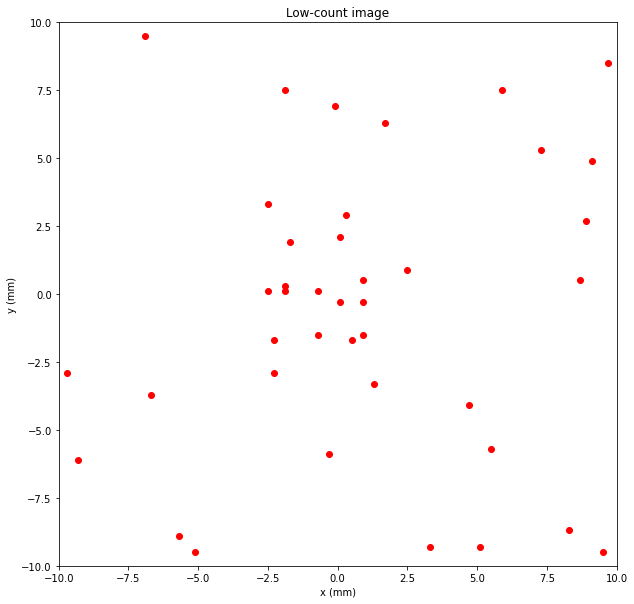

In [2]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

ax.set_title("Low-count image")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

ax.scatter(pos_x, pos_y, color="red")

plt.show()

The distribution of counts for signal over flat background in the plane follows a 2D Gaussian centered at `(0, 0)` with `sigma2 = 2 mm2`. We normalise each of the terms so that the integral over the whole plane (`-10 < x < 10`, `-10 < y < 10`) is exactly `B + S` (this is a usual convention). The first term gives `400*B`, and the second `4*pi*S*erf(5)^2 = 12.5664*S`. On the other hand, since it's a PDF, its integral over the whole space (`-10 < x < 10`, `-10 < y < 10` in our case) must be `1`. Therefore, we divide the whole function over `B+S`:

In [3]:
@jit
def distr(B, S, x, y, sigma2=2):
    return (B / 400 + (S / 12.5664) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma2)))/(B+S) 

We have a small number of counts in the space, so we'll use the unbinned likelihood with an extra Poissonian term (with mean `B+S`) to account for the total number of events registered `N` (this means we're assuming the total number `N` is also a random variable and not fixed):

In [4]:
from scipy.stats import poisson

def log_likelihood(B, S):
    res = 1
    for i in range(N):
        res = res*distr(B=B, S=S, x=pos_x[i], y=pos_y[i]) # Unbinned likelihood: product over all the individual events (not bins)
    res = res*poisson(B+S).pmf(N) # Extra Poissonian term with mean B+S
    res = -2*np.log(res) # -2*log() so we minimize instead of maximize
    return res

Let's proceed with the minimization of our log-likelihood:

In [5]:
def minimize_loglike(N):
    S_res = 0
    B_res = 0

    log_min = 1e10

    for S in np.linspace(0.1, 40, N):
        for B in np.linspace(0.1, 40, N):
            loglike = log_likelihood(B=B, S=S)
            if loglike < log_min:
                log_min = loglike
                B_res = B
                S_res = S

    return log_min, B_res, S_res


log_min, B_min, S_min = minimize_loglike(N=100)

print(f"B={B_min:0.1f}, S={S_min:0.1f}, logmin={log_min:0.1f}")

B=26.7, S=13.4, logmin=456.3


We now plot the likelihood function in two scenarios: fixed `B_min`, varying `S`; varying `B`, fixed `S_min`: 

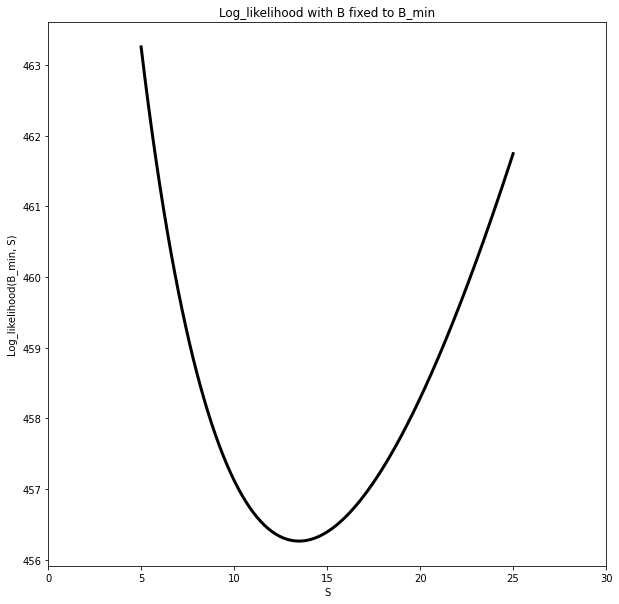

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 30])

ax.set_xlabel("S")
ax.set_ylabel("Log_likelihood(B_min, S)")
ax.set_title("Log_likelihood with B fixed to B_min")

S = np.linspace(5, 25, 200)
ax.plot(S, log_likelihood(B=B_min, S=S), color="black", linewidth=3)

plt.show()

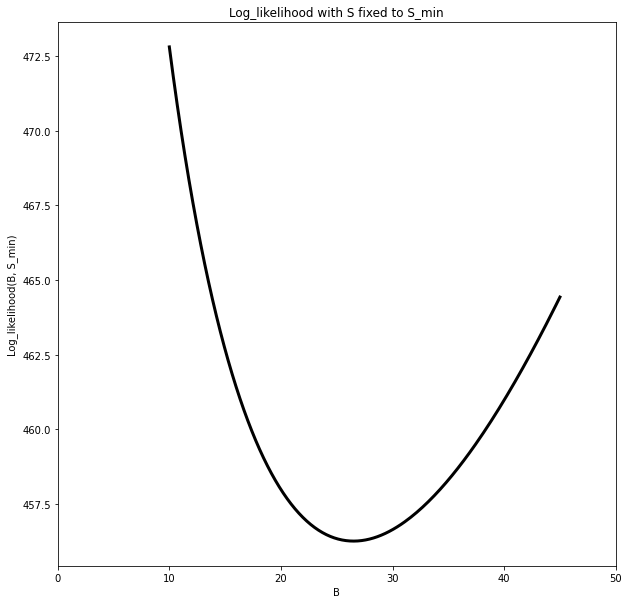

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 50])

ax.set_xlabel("B")
ax.set_ylabel("Log_likelihood(B, S_min)")
ax.set_title("Log_likelihood with S fixed to S_min")

B = np.linspace(10, 45, 200)
ax.plot(B, log_likelihood(B, S=S_min), color="black", linewidth=3)

plt.show()

We can also find the uncertainties for both parameters. We'll use the likelihood scan method: we find the interval for each of the plots above such that the change in the log likelihood is `+1` with respect to the minimum: 

In [8]:
def find_interval(N=100):
    
    minimum = log_likelihood(B_min, S_min)
    
    # B error: we let B vary
    for i in np.linspace(0.01, B_min, N):
        if log_likelihood(B=i, S=S_min) - minimum < 1:
            B_lower_limit = B_min - i
            break
            
    for i in reversed(np.linspace(B_min, 40, N)):
        if log_likelihood(B=i, S=S_min) - minimum < 1:
            B_upper_limit = i - B_min
            break
    
    B_error = max(B_lower_limit, B_upper_limit)
    
    # S error: we let S vary
    for i in np.linspace(0.01, S_min, N):
        if log_likelihood(B=B_min, S=i) - minimum < 1:
            S_lower_limit = S_min - i
            break
           
    for i in reversed(np.linspace(S_min, 40, N)):
        if log_likelihood(B=B_min, S=i) - minimum < 1:
            S_upper_limit = i - S_min
            break
    
    S_error = max(S_lower_limit, S_upper_limit)
    
    return B_error, S_error


B_error, S_error = find_interval(N=100)

print(f"Uncertainty of B = {B_error:0.1f}, confidence interval: {B_min:0.1f} ± {B_error:0.1f}")
print(f"Uncertainty of S = {S_error:0.1f}, confidence interval: {S_min:0.1f} ± {S_error:0.1f}")

Uncertainty of B = 5.5, confidence interval: 26.7 ± 5.5
Uncertainty of S = 4.3, confidence interval: 13.4 ± 4.3


Finally, we can plot some level curves of our fitted 2D function:

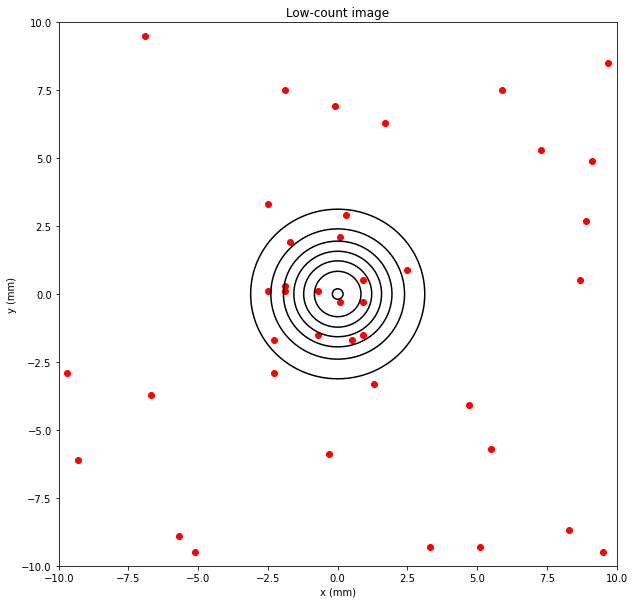

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

ax.set_title("Low-count image")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

ax.scatter(pos_x, pos_y, color="red")

xlist = np.linspace(-4.0, 4.0, 100)
ylist = np.linspace(-4.0, 4.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = distr(B_min, S_min, X, Y, sigma2=2)
ax.contour(X, Y, Z, colors="black")

plt.show()